In [57]:
"""
    Script to stream news articles and compare sentiment against cryptocurrency price
    Author: Ross MacWilliam
    Date: 01/02/2021
"""

import re
import csv
from time import sleep
import requests
import json
import pandas as pd
import numpy as np
import requests
import bs4
from bs4 import BeautifulSoup
from datetime import datetime, timedelta, date

import pandas_datareader as pdr
import matplotlib.pyplot as plt

import shrimpy
import plotly.graph_objects as go
from newsapi import NewsApiClient
from yahoofinancials import YahooFinancials
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [58]:
overall_headlines = pd.read_csv('.\datasets\overall_sentiment.csv')

In [10]:
def calculate_extreme_scores(high_headlines, trading_symbol):
    high_headlines['times'] = pd.to_datetime(high_headlines['publishedAt'])
    high_headlines['hour'] = high_headlines['times'].dt.date.astype(str) + ' ' +high_headlines['times'].dt.hour.astype(str)+ ':00'
    grouped_dates = high_headlines.groupby([high_headlines['hour']])
    keys_dates = list(grouped_dates.groups.keys())

    max_cs = []
    min_cs = []

    for key in grouped_dates.groups.keys():
        data = grouped_dates.get_group(key)
        if data["compound"].max() > .2:
            max_cs.append(data["compound"].max())
        elif data["compound"].max() < -.2:
            max_cs.append(0)

        if data["compound"].min() < 0:
            min_cs.append(data["compound"].min())
        elif data["compound"].min() > 0:
            min_cs.append(0)

    extreme_scores_dict = {'Date':keys_dates,'max_scores':max_cs,'min_scores':min_cs}
    extreme_scores_df = pd.DataFrame(extreme_scores_dict)

    final_scores = []
    for i in range(len(extreme_scores_df)):
        final_scores.append(extreme_scores_df['max_scores'].values[i] + extreme_scores_df['min_scores'].values[i])

    extreme_scores_df['final_scores'] = final_scores

        
    #sentiment_Buy, sentiment_Sell = self.make_trade_call(extreme_scores_df)
        
    #self.vizualise_calls(trading_symbol, sentiment_Buy, sentiment_Sell)
        
    return extreme_scores_df

In [36]:
def get_latest_prices(trading_symbol):
    public_key = '12326758a39a720e15d064cab3c1f0a9332d107de453bd41926bb3acd565059e'
    secret_key = '6991cf4c9b518293429db0df6085d1731074bed8abccd7f0279a52fac5b0c1a8a2f6d28e11a50fbb1c6575d1407e637f9ad7c73fbddfa87c5d418fd58971f829'
    
    client = shrimpy.ShrimpyApiClient(public_key, secret_key)
        
    # get the candles for historical values
    candles = client.get_candles(
        'binance',  # exchange
        trading_symbol,      # base_trading_symbol
        'USDT',      # quote_trading_symbol
        '1h'       # interval
    )
        
    # Set the dataframe between these two dates
    tomorrows_date = (datetime.today() + timedelta(days=1)).strftime("%Y-%m-%d")
    starting_date = '2021-01-25'

    # Put pulled cryptocurrency values into a dataframe and set dates
    prices_df = pd.DataFrame(candles)
    prices_df['time'] = pd.to_datetime(prices_df['time'], infer_datetime_format=True).dt.tz_localize(None)

    latest_prices = prices_df[(prices_df['time'] > starting_date) & (prices_df['time'] <tomorrows_date)]
    latest_prices['close'] = latest_prices['close'].astype('float64')

    return latest_prices

In [37]:
prices_df = get_latest_prices('BTC')

<ipython-input-36-f82d79822a4f>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_prices['close'] = latest_prices['close'].astype('float64')


In [190]:
interval_scores = calculate_extreme_scores(overall_headlines, 'BTC')

In [191]:
interval_scores

,Date,max_scores,min_scores,final_scores
0,2021-01-25 10:00,0.9766,0.0000,0.9766
1,2021-01-25 12:00,0.9818,0.0000,0.9818
2,2021-01-25 13:00,0.7717,0.0000,0.7717
3,2021-01-25 14:00,0.0000,-0.8126,-0.8126
4,2021-01-25 15:00,0.9682,0.0000,0.9682
...,...,...,...,...
134,2021-02-02 3:00,0.0000,-0.6705,-0.6705
135,2021-02-02 5:00,0.0000,-0.9997,-0.9997
136,2021-02-02 6:00,0.0000,-0.6705,-0.6705
137,2021-02-02 7:00,0.9477,0.0000,0.9477


In [192]:
extreme_scores_df = interval_scores

In [193]:
#extreme_scores_df['pandas_SMA_3'] = extreme_scores_df.iloc[:,1].rolling(window=21).mean()

extreme_scores_df.index =  pd.DatetimeIndex(extreme_scores_df['Date'])
extreme_scores_df = extreme_scores_df.drop(['Date'], axis=1)

extreme_scores_df = extreme_scores_df.asfreq('H')
#extreme_scores_df['pandas_SMA_3'] = extreme_scores_df.iloc[:,1].rolling(window=21).mean()
extreme_scores_df

,max_scores,min_scores,final_scores
Date,,,
2021-01-25 10:00:00,0.9766,0.0000,0.9766
2021-01-25 11:00:00,NaN,NaN,NaN
2021-01-25 12:00:00,0.9818,0.0000,0.9818
2021-01-25 13:00:00,0.7717,0.0000,0.7717
2021-01-25 14:00:00,0.0000,-0.8126,-0.8126
...,...,...,...
2021-02-02 05:00:00,0.0000,-0.9997,-0.9997
2021-02-02 06:00:00,0.0000,-0.6705,-0.6705
2021-02-02 07:00:00,0.9477,0.0000,0.9477


In [199]:
extreme_scores_df['SMA'] = extreme_scores_df.final_scores.rolling(window=48,min_periods=1).mean()
extreme_scores_df

,max_scores,min_scores,final_scores,SMA
Date,,,,
2021-01-25 10:00:00,0.9766,0.0000,0.9766,0.976600
2021-01-25 11:00:00,NaN,NaN,NaN,0.976600
2021-01-25 12:00:00,0.9818,0.0000,0.9818,0.979200
2021-01-25 13:00:00,0.7717,0.0000,0.7717,0.910033
2021-01-25 14:00:00,0.0000,-0.8126,-0.8126,0.479375
...,...,...,...,...
2021-02-02 05:00:00,0.0000,-0.9997,-0.9997,-0.019869
2021-02-02 06:00:00,0.0000,-0.6705,-0.6705,-0.037454
2021-02-02 07:00:00,0.9477,0.0000,0.9477,-0.011529


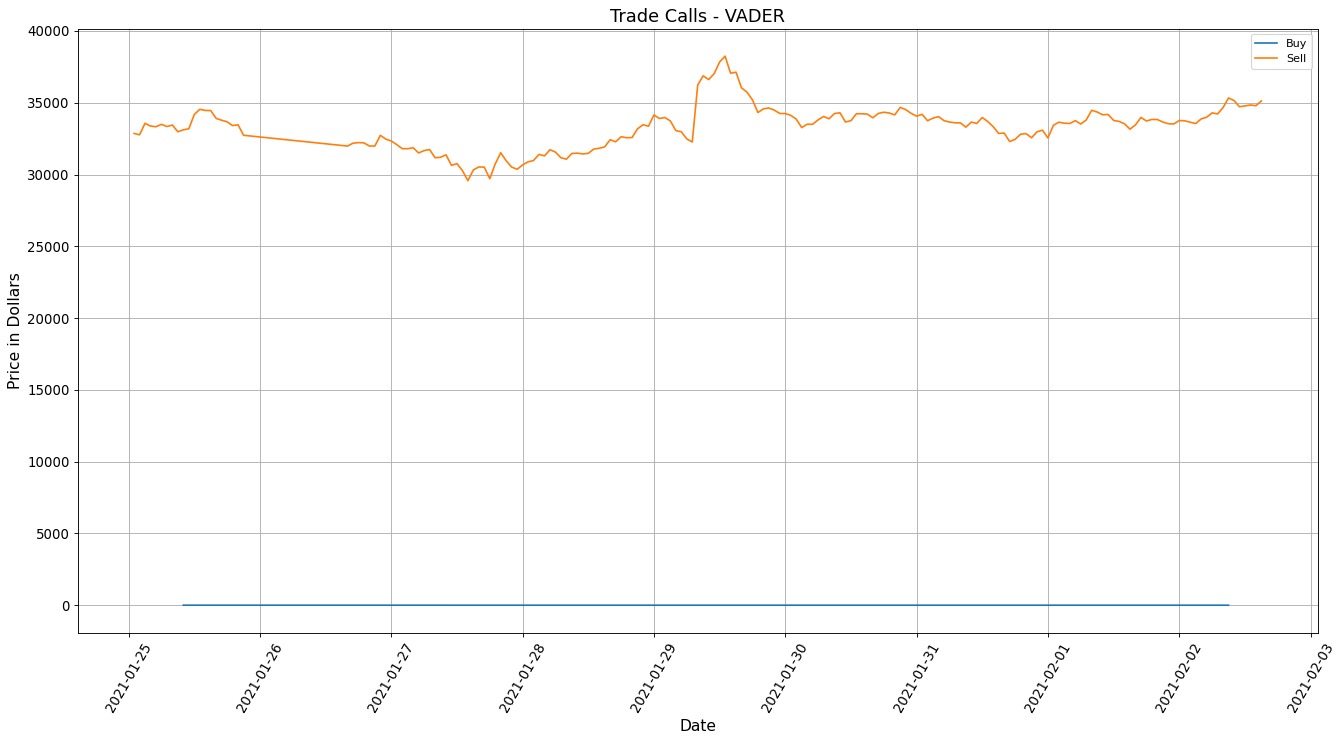

In [201]:
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(extreme_scores_df.index,extreme_scores_df['SMA'])
plt.plot(prices_df['time'],prices_df['close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - VADER', fontsize = 16)
plt.legend(['Buy','Sell','Close'])
plt.grid()
plt.show() 

In [196]:
extreme_scores_df.to_csv(f'.\df.csv', index=False)

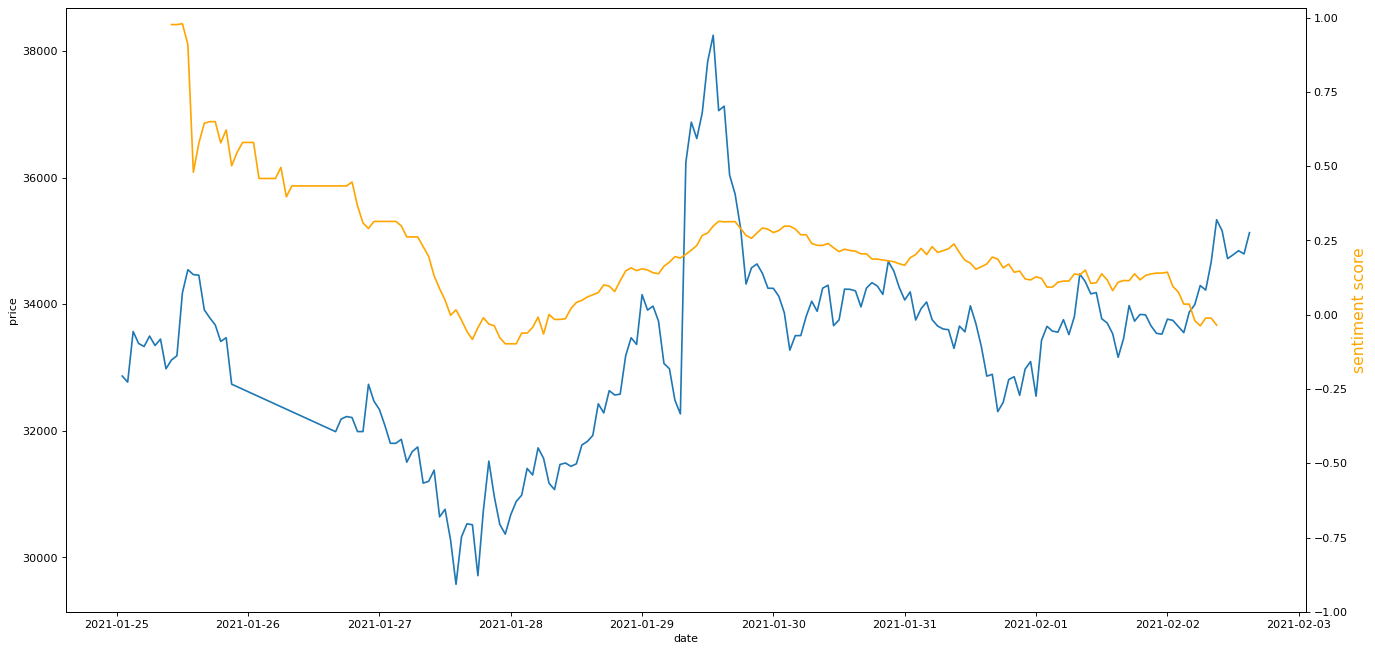

In [211]:
# create figure and axis objects with subplots()
fig,ax=plt.subplots(figsize=(20, 10),dpi=80)
ax.plot(prices_df['time'],prices_df['close'])
ax.set_xlabel("date")
ax.set_ylabel("price")
#ax.plot(prices_df['time'],prices_df['close'])
#plt.show()

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(extreme_scores_df.index,extreme_scores_df['SMA'],color="orange")
ax2.set_ylabel("sentiment score",color="orange",fontsize=14)
ax2.set_ylim(ymin=-1)
plt.show()